In [1]:
import numpy as np
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM

import sys
sys.path.append("../../../../pymatsolver/")
from pymatsolver import PardisoSolver
sys.path.append("../../../../../Dropbox/PhD_UBC/telluricpy/")
import telluricpy

# Set some matplotlib settings
%matplotlib inline


Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

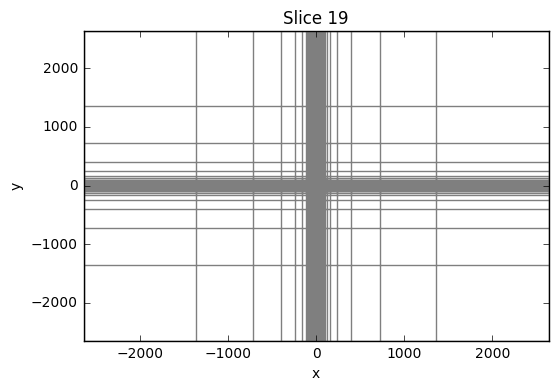

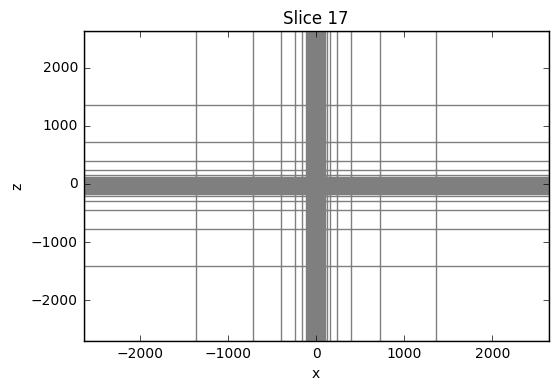

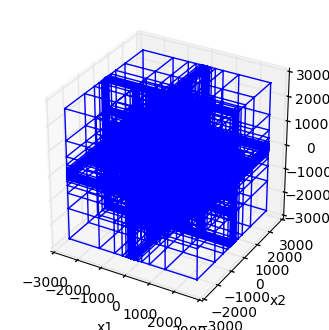

45084
139060


In [71]:
#Cell size
csx, csy, csz = 10.,10.,10.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 20,20,25.
# Number of padding cells to add in each direction
npad = 7
growrate = 2.
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -growrate),(csx,ncx),(csx,npad,growrate)]
hy = [(csy,npad, -growrate),(csy,ncy),(csy,npad, growrate)]
hz = [(csz,npad,-growrate),(csz,ncz),(csy,npad, growrate)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,npad,growrate)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 100
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
mesh.plotGrid()
plt.gca().set_aspect('equal')
plt.show()

print mesh.nC
print mesh.nF

In [72]:
sig_air = 1e-8
sphere_depth = 100.
sig_back = 1e-2
sig_sphere = 1e-1
sphere_r = 50.
sigma = sig_back*np.ones(mesh.nC)

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

#Define the sphere limit
inds = (np.sqrt((mesh.gridCC[:,2]+sphere_depth)**2.+(mesh.gridCC[:,1])**2.+(mesh.gridCC[:,0])**2.))< sphere_r
sigma[inds] = sig_sphere

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

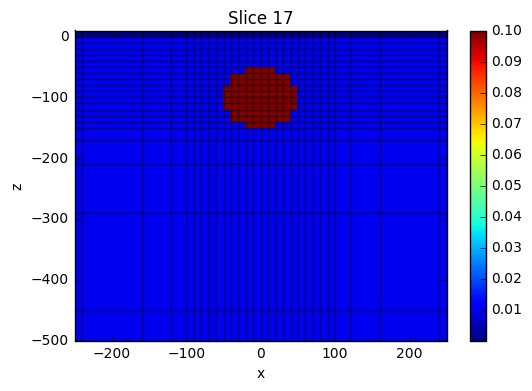

In [73]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
plt.gca().set_xlim([-250.,250])
plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [74]:
freqs = np.logspace(5,2,13)
print freqs

[ 100000.           56234.13251903   31622.77660168   17782.79410039
   10000.            5623.4132519     3162.27766017    1778.27941004
    1000.             562.34132519     316.22776602     177.827941       100.        ]


In [75]:
print 500./np.sqrt(freqs*sig_back)

[  15.8113883    21.08482517   28.11706626   37.49471047   50.
   66.67607161   88.9139705   118.56868528  158.11388301  210.84825171
  281.1706626   374.94710467  500.        ]


In [79]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-100,101,10),np.arange(-100,101,10),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [80]:
locs

array([[-100., -100.,    0.],
       [ -90., -100.,    0.],
       [ -80., -100.,    0.],
       ..., 
       [  80.,  100.,    0.],
       [  90.,  100.,    0.],
       [ 100.,  100.,    0.]])

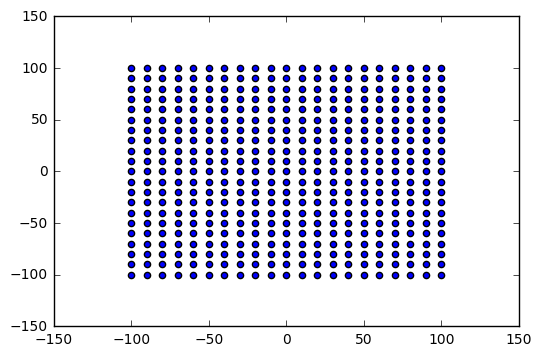

In [81]:
plt.scatter(locs[:,0],locs[:,1])

In [82]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2016-12-21 16:18:57
Starting work for 1.000e+02
Ran for 96.076000 seconds
Starting work for 1.778e+02
Ran for 99.237000 seconds
Starting work for 3.162e+02
Ran for 99.112000 seconds
Starting work for 5.623e+02
Ran for 102.354000 seconds
Starting work for 1.000e+03
Ran for 97.162000 seconds
Starting work for 1.778e+03
Ran for 96.607000 seconds
Starting work for 3.162e+03
Ran for 96.604000 seconds
Starting work for 5.623e+03
Ran for 95.791000 seconds
Starting work for 1.000e+04
Ran for 96.133000 seconds
Starting work for 1.778e+04
Ran for 102.609000 seconds
Starting work for 3.162e+04
Ran for 98.403000 seconds
Starting work for 5.623e+04
Ran for 102.179000 seconds
Starting work for 1.000e+05
Ran for 101.180000 seconds
Ended calculation field at 2016-12-21 16:40:24
Ran for 1287.632000
Starting projecting fields to data at 2016-12-21 16:40:24
Ended projection of fields at 2016-12-21 16:41:00
Ran for 35.669000


In [83]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('sphere_mtData_1e2_1e1.pklb','wb'))

In [44]:
mtData = dill.load(open('sphere_mtData_1e2_1e1.pklb','rb'))

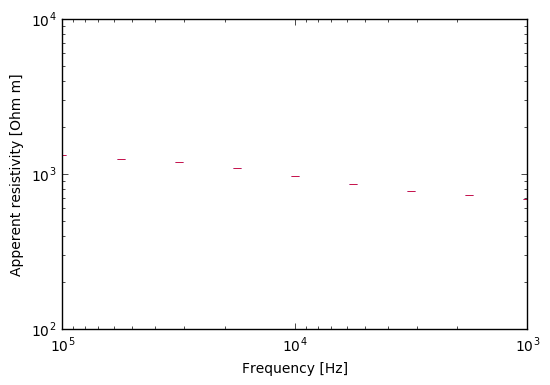

In [45]:
mtData.plot_app_res(np.array([0.,0.]))

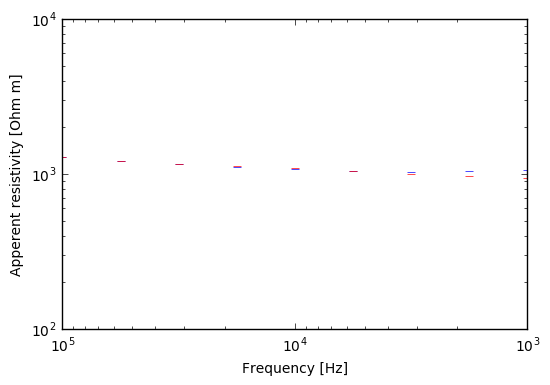

In [46]:
mtData.plot_app_res(np.array([-250.,0.]))